# CRDCDH Semantic Mapping with BlazingText



The Amazon SageMaker BlazingText algorithm provides highly optimized implementations of the Word2vec and text classification algorithms. The Word2vec algorithm is useful for many downstream natural language processing (NLP) tasks, such as sentiment analysis, named entity recognition, machine translation, etc. Text classification is an important task for applications that perform web searches, information retrieval, ranking, and document classification.  Moreover, it supports Out-of-vocabulary (OOV) to predict words that are not in training dataset with much higher performance than FastText.

## Setup

Let's start by setting SageMaker environment:
- For the first time to run the notebook, make sure sageMaker environment configuration file, sagemaker_config.py, exists in src/common directory.  If not, create it by copy sagemaker_config_sample.py file under src/common dir and rename the copy to sagemaker_config.py
- Open the sagemaker_config.py under src/common dir, review all environment settings and update them if necessary. 

In [13]:
from semantic_analysis_class import SemanticAnalysis
import common.sagemaker_config as config

# instantiate a class object from SemanticAnalysis and set SageMaker environment
semantic_analysis = SemanticAnalysis()


## Training and/or Test Model Setup
First of all, set the container by calling:
    semantic_analysis.set_container(container_name, container_version)


In [14]:
CONTAINER_IMAGE_NAME = "blazingtext"
CONTAINER_IMAGE_VERSION = "latest"
semantic_analysis.set_container(CONTAINER_IMAGE_NAME, CONTAINER_IMAGE_VERSION)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


Second, decide train and/or test model workflow by setting switches:

By setting TEST_MODEL_ONLY to false, we decide to train model and test model.  Otherwise, only test trained model, that skips training step, a very costly step.
    1) TEST_MODEL_ONLY = False  
   
By setting TRANSFORM_DATA to false, we decide to use existing training data in text8 format.  Otherwise, need call transformData function to convert json files to a text8 file .
    2) TRANSFORM_DATA = False 


In [15]:
#setting switches to determine workflow
TEST_MODEL_ONLY = False 
TRANSFORM_DATA = False 
UPDATE_ENDPOINT = True

trained_model_s3_path = ""

if TEST_MODEL_ONLY == True:
    #must set trained model s3 path here
    trained_model_s3_path = "train_output/blazingtext-2024-06-21-14-56-31-917/output/model.tar.gz"

For train model, need to prepare training data, if only have datasets in json files, need call transform function to create a one training file in text8 format

In [16]:
trining_data_s3_path = "" 
if TEST_MODEL_ONLY == False:
    if TRANSFORM_DATA == True:
        # if need to transform data, must set the raw data folder that contain json file(s) either in s3 bucket of in local folder
        # contact admin if you don't have it.
        s3_raw_data_prefix = "data/raw/json/blazingtext-2024-06-13-16-15/" 
        trining_data_s3_path = semantic_analysis.transformData(s3_raw_data_prefix)
    else:
        # if not need to transform data, must set the training data file path in s3 bucket, contact admin if you don't have it.
        # trining_data_s3_path = "data/train/blazingtext-2024-06-21-10-51-45-535/train_data_text8"
        # or local path to the training dataset.
        trining_data_local_path = "../data/train/text8/evaluation_data_set.txt"
    path = trining_data_s3_path if trining_data_s3_path else trining_data_local_path
    print(f"Training data path: {path}")
    #call prepare_train_data function
    semantic_analysis.prepare_train_data(trining_data_s3_path, trining_data_local_path)

Training data path: ../data/train/text8/evaluation_data_set.txt
Upload training data to s3 bucket, data/train/blazingtext-2024-06-25-15-36-50-250/train_data_text8.


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Training data uploaded to s3 bucket, data/train/blazingtext-2024-06-25-15-36-50-250/train_data_text8.


## Training the BlazingText model for generating word vectors

Now let's train the model.

In [17]:
if TEST_MODEL_ONLY == False:
    # Train the model
    #set training algorithm
    algorithm = "FastText"  #values: "FastText", "Word2Vec, TextClassification"
    semantic_analysis.train(algorithm)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: blazingtext-2024-06-25-19-36-51-384


2024-06-25 19:36:51 Starting - Starting the training job...
2024-06-25 19:37:09 Starting - Preparing the instances for training...
2024-06-25 19:37:40 Downloading - Downloading input data...
2024-06-25 19:38:20 Training - Training image download completed. Training in progress...Arguments: train
[06/25/2024 19:38:27 WARNING 140153678784320] Loggers have already been setup.
[06/25/2024 19:38:27 WARNING 140153678784320] Loggers have already been setup.
/opt/amazon/python3.8/lib/python3.8/subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
[06/25/2024 19:38:27 INFO 140153678784320] nvidia-smi took: 0.02518463134765625 secs to identify 0 gpus
[06/25/2024 19:38:27 INFO 140153678784320] Running single machine CPU BlazingText training using skipgram mode.
Number of CPU sockets found in instance is  1
[06/25/2024 19:38:27 INFO 140153678784320] Processing /opt/ml/inpu

### Evaluation

Let us now download the word vectors learned by our model and visualize them using a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) plot.

train_output/blazingtext-2024-06-25-19-36-51-384/output/model.tar.gz


/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


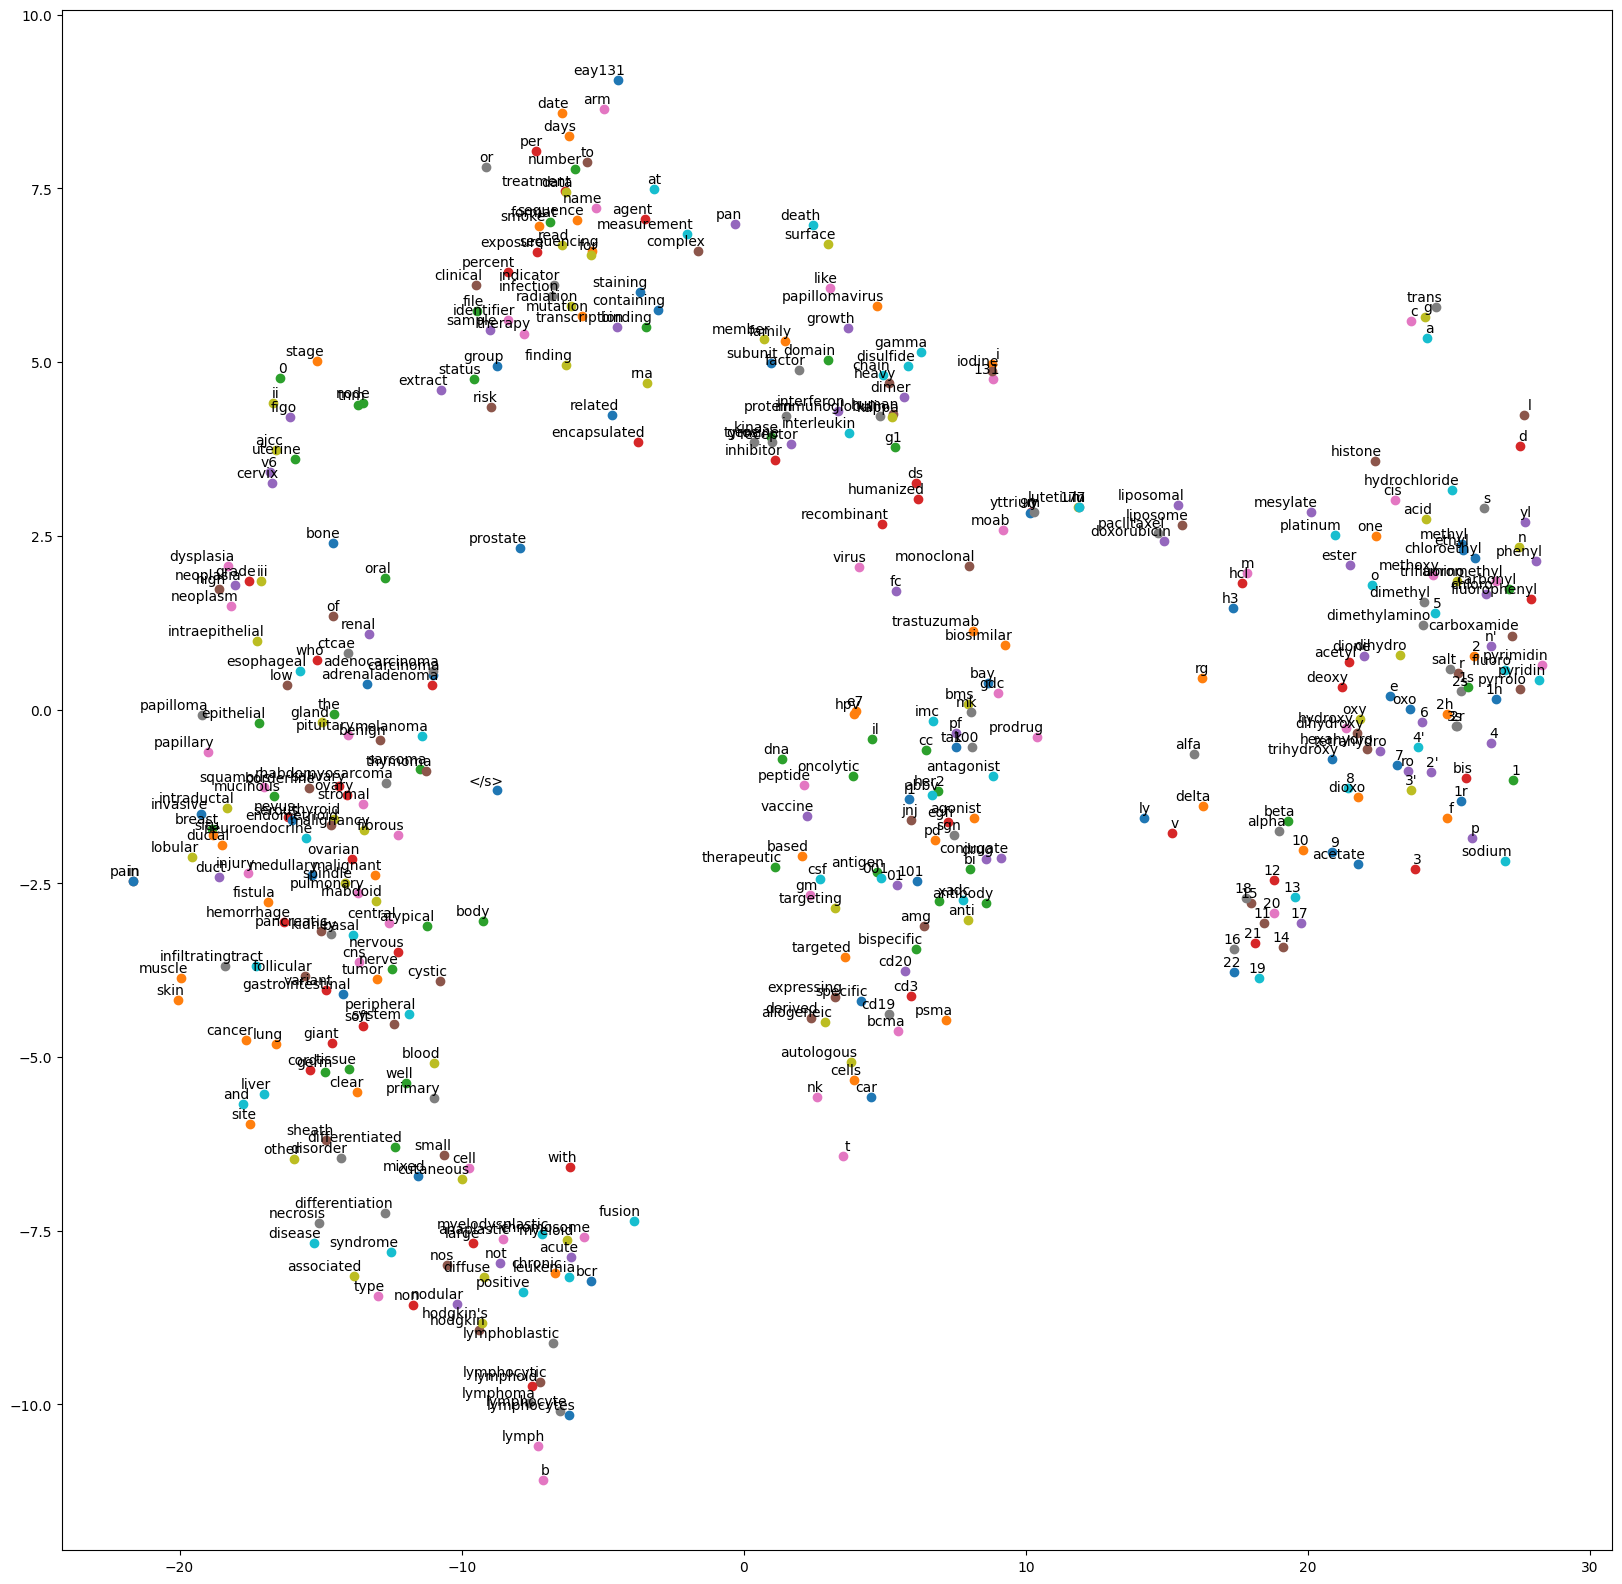

In [18]:
if TEST_MODEL_ONLY == False:
    downloaded_model_path = "../output/model.tar.gz"
    semantic_analysis.download_trained_model(downloaded_model_path) # download trained model to local
    semantic_analysis.evaluate_learned_model_vacs(downloaded_model_path, "../output/model") # evaluate learned vectors in trained model

As expected, we get an n-dimensional vector (where n is vector_dim as specified in hyperparameters) for each of the words. If the word is not there in the training dataset, the model will return a vector of zeros.

Running the code above might generate a plot like the one below. t-SNE and Word2Vec are stochastic, so although when you run the code the plot won’t look exactly like this, you can still see clusters of similar words such as below where 'british', 'american', 'french', 'english' are near the bottom-left, and 'military', 'army' and 'forces' are all together near the bottom.

![tsne plot of embeddings](../images/tsne.png)

## Hosting / Inference
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same type of instance that we used to train. Because instance endpoints will be up and running for long, it's advisable to choose a cheaper instance for inference.

In [19]:
endpoint_name = config.ENDPOINT_NAME #default endpoint name, crdcdh-ml-dev-endpoint in dev. The name can be customized by valid unique name.
if UPDATE_ENDPOINT:
    semantic_analysis.deploy_trained_model(endpoint_name, trained_model_s3_path)

INFO:sagemaker:Creating model with name: blazingtext-2024-06-25-19-40-02-541
INFO:sagemaker:Creating endpoint-config with name crdcdh-ml-loc-endpoint
INFO:sagemaker:Creating endpoint with name crdcdh-ml-loc-endpoint


-----!

### Check the accuracy of predictions with test dataset

#### Use YAML format for inference
Extract permissive and non-permissive value pairs then calculate mean similarity by compare word embeddings (vectors) of values paris.

In [20]:
EVALUATE_MODEL = True
if EVALUATE_MODEL:
    yaml_test_data_path = "../data/test/cds_clean_dict_v1.3.yaml" # set the local yaml file path 
    semantic_analysis.evaluate_trained_model(endpoint_name, yaml_test_data_path)

Non-permissove/permissive pairs: [('pediatric', 'Pediatric'), ('adult', 'Adult'), ('Pediatric, pediatric', 'Pediatric'), ('paired', 'Paired-end'), ('Single', 'Single-end'), ('Paired End', 'Paired-end'), ('Paired-end', 'Paired-end'), ('Paired end', 'Paired-end'), ('paired-end', 'Paired-end'), ('paired_end', 'Paired-end')]
Total paired words: 1694
[1.0, 1.0, 0.9995569173896652, 0.9325471567463672, 0.9906098422274746, 0.9950581483243579, 1.0, 0.9950581483243579, 1.0, 0.9950175616520998]
Mean similarity: 0.9880


### Getting vector representations for two words and get similarity score

In [21]:
words = ["gender", "female"]   
semantic_analysis.test_trained_model(words, endpoint_name)

[{'vector': [-0.30276837944984436, 0.17517781257629395, -0.5966138243675232, -0.22543330490589142, 0.23853810131549835, -0.036202605813741684, 0.47091144323349, 0.20315125584602356, 0.11252325028181076, 0.44628557562828064, -0.07452240586280823, 0.06382419914007187, -0.33426138758659363, 0.0827469676733017, -0.4981377422809601, -0.11166633665561676, -0.04624249413609505, 0.5763659477233887, 0.01295750867575407, -0.6566001772880554, -0.016237901523709297, 0.38370493054389954, -0.1636982560157776, 0.1272435486316681, -0.26614993810653687, -0.04557957872748375, -0.3374021351337433, 0.06558169424533844, 0.03598293289542198, 0.43346986174583435, -0.06309564411640167, -0.4115985929965973, -0.038250282406806946, 0.23080706596374512, 0.11852264404296875, -0.1700771600008011, 0.37636598944664, -0.517837643623352, -0.2706505060195923, -0.487378865480423, 0.6859171986579895, -0.024036018177866936, 0.11383569240570068, -0.1485784351825714, 0.10183112323284149, 0.04086831584572792, -0.2237529009580

## Search similar words by a given word

In [28]:
word = "cancer"
semantic_analysis.search_similar_words(word, endpoint_name, 10)

cancer:[-0.3579435348510742, 0.21036997437477112, -0.6714670658111572, -0.3059942424297333, 0.5475789904594421, -0.10092572867870331, 0.3450706899166107, 0.38346362113952637, 0.030949560925364494, 0.34553802013397217, -0.04709779843688011, -0.00027998184668831527, -0.36717644333839417, 0.025175759568810463, -0.6014472842216492, -0.10694903135299683, -0.2777065634727478, 0.514367938041687, 0.02937561832368374, -0.6187590956687927, 0.2312980443239212, 0.3453643023967743, -0.08909378945827484, 0.3224126696586609, -0.21947471797466278, -0.06856648623943329, -0.30242669582366943, -0.19732557237148285, -0.10043340921401978, 0.51304030418396, -0.20601344108581543, -0.6369844675064087, -0.11444330215454102, 0.35362276434898376, 0.128732830286026, -0.06820248067378998, 0.28899046778678894, -0.36921098828315735, -0.17750509083271027, -0.41416075825691223, 0.8039255142211914, 0.1449531763792038, 0.13016611337661743, -0.3176320195198059, 0.03472984954714775, -0.11270462721586227, -0.34212711453437

[('cancer', 0.999999999965292),
 ('calcifying', 0.9840694087229542),
 ('ossifying', 0.9704983437220058),
 ('tract', 0.9677369744018784),
 ('product', 0.967052615074717),
 ('keratinizing', 0.9666714486486001),
 ('secretory', 0.9656028043602123),
 ('cort', 0.9646979609173971),
 ('congenital', 0.962834059085086),
 ('genital', 0.9618918933577596)]

### Stop / Close the Endpoint (Optional)
Finally, for training and test purpose, we need delete the endpoint before we close the notebook.  If you want to host the model in the endpoint for a while, just remove the endpoint_name parameter from the close() as listed below:

semantic_analysis.close()

In [23]:
CONTINUE = True
if not CONTINUE:
    # # Delete the SageMaker endpoint and resources
    # semantic_analysis.close(0, endpoint_name)
    semantic_analysis.close(0)
    semantic_analysis = None
    s3_bucket = None